In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
import os
os.chdir('/content/drive/My Drive/Pose Estimation/orvee/Pretrained openpose')

Mounted at /content/drive


In [ ]:
from __future__ import division
import os
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt


class general_pose_model(object):
    def __init__(self, modelpath):
        self.num_points = 22
        self.point_pairs = [[0,1],[1,2],[2,3],[3,4],
                            [0,5],[5,6],[6,7],[7,8],
                            [0,9],[9,10],[10,11],[11,12],
                            [0,13],[13,14],[14,15],[15,16],
                            [0,17],[17,18],[18,19],[19,20]]
        # self.inWidth = 368
        self.inHeight = 368
        self.threshold = 0.1
        self.hand_net = self.get_hand_model(modelpath)

# class general_pose_model(object):
#     def __init__(self, modelpath):
#         self.num_points = 22
#         self.point_pairs = [[0,1],[1,2],[2,3],[3,4],
#                             [0,5],[5,6],[6,7],[7,8],
#                             [0,9],[9,10],[10,11],[11,12],
#                             [0,13],[13,14],[14,15],[15,16],
#                             [0,17],[17,18]]
        # # self.inWidth = 368
        # self.inHeight = 368
        # self.threshold = 0.1
        # self.hand_net = self.get_hand_model(modelpath)


    def get_hand_model(self, modelpath):

        prototxt   = os.path.join(modelpath, "pose_deploy.prototxt")
        caffemodel = os.path.join(modelpath, "pose_iter_102000.caffemodel")
        
#         prototxt   =  "hand_models/pose_deploy.prototxt"
#         caffemodel =  "hand_models/pose_iter_102000.caffemodel"
        hand_model = cv2.dnn.readNetFromCaffe(prototxt, caffemodel)

        return hand_model


    def predict(self, imgfile):
        img_cv2 = cv2.imread(imgfile)
        img_height, img_width, _ = img_cv2.shape
        aspect_ratio = img_width / img_height

        inWidth = int(((aspect_ratio * self.inHeight) * 8) // 8)
        inpBlob = cv2.dnn.blobFromImage(img_cv2, 1.0 / 255, (inWidth, self.inHeight), (0, 0, 0), swapRB=False, crop=False)

        self.hand_net.setInput(inpBlob)

        output = self.hand_net.forward()

        # vis heatmaps
        self.vis_heatmaps(imgfile, output)

        #
        points = []
        for idx in range(self.num_points):
            probMap = output[0, idx, :, :] # confidence map.
            probMap = cv2.resize(probMap, (img_width, img_height))

            # Find global maxima of the probMap.
            minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)

            if prob > self.threshold:
                points.append((int(point[0]), int(point[1])))
            else:
                points.append(None)

        return points


    def vis_heatmaps(self, imgfile, net_outputs):
        img_cv2 = cv2.imread(imgfile)
        plt.figure(figsize=[10, 10])

        for pdx in range(self.num_points):
            probMap = net_outputs[0, pdx, :, :]
            probMap = cv2.resize(probMap, (img_cv2.shape[1], img_cv2.shape[0]))
            plt.subplot(5, 5, pdx+1)
            plt.imshow(cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB))
            plt.imshow(probMap, alpha=0.6)
            plt.colorbar()
            plt.axis("off")
        plt.show()


    def vis_pose(self, imgfile, points):
        img_cv2 = cv2.imread(imgfile)
        img_cv2_copy = np.copy(img_cv2)
        for idx in range(len(points)):
            if points[idx]:
                cv2.circle(img_cv2_copy, points[idx], 8, (0, 255, 255), thickness=-1,
                           lineType=cv2.FILLED)
                cv2.putText(img_cv2_copy, "{}".format(idx), points[idx], cv2.FONT_HERSHEY_SIMPLEX,
                            1, (0, 0, 255), 2, lineType=cv2.LINE_AA)

        # Draw Skeleton
        for pair in self.point_pairs:
            partA = pair[0]
            partB = pair[1]

            if points[partA] and points[partB]:
                cv2.line(img_cv2, points[partA], points[partB], (0, 255, 255), 3)
                cv2.circle(img_cv2, points[partA], 8, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)

        plt.figure(figsize=[10, 10])
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(img_cv2_copy, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.show()

# if __name__ == '__main__':
#     print("[INFO]Pose estimation.")
#     imgs_path = "RESIZED_TESTING_DATA"
#     img_files = [os.path.join(imgs_path, img_file) for img_file in os.listdir(imgs_path)]
#     #img_files ="RESIZED_DATASET//0//"
#     start = time.time()
#     modelpath = "hand_models"
#     pose_model = general_pose_model(modelpath)
#     print("[INFO]Model loads time: ", time.time() - start)

#     for img_file in img_files:
#         pic = os.listdir(img_file)
#         start = time.time()
#         res_points = pose_model.predict(pic)
#         print("[INFO]Model predicts time: ", time.time() - start)
#         pose_model.vis_pose(pic, res_points)

#     print("[INFO]Done.")

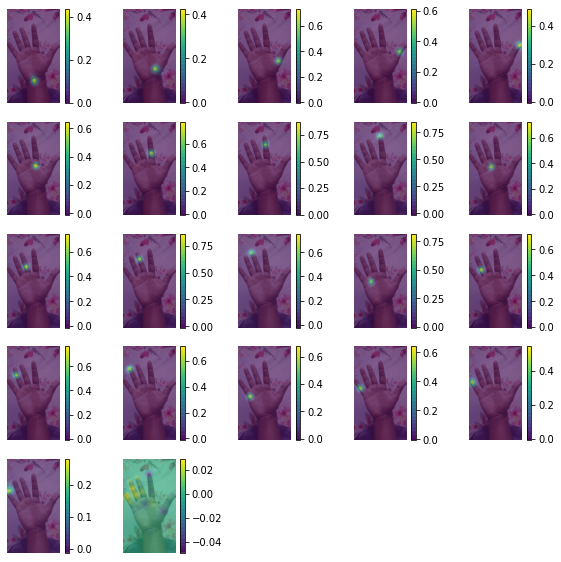

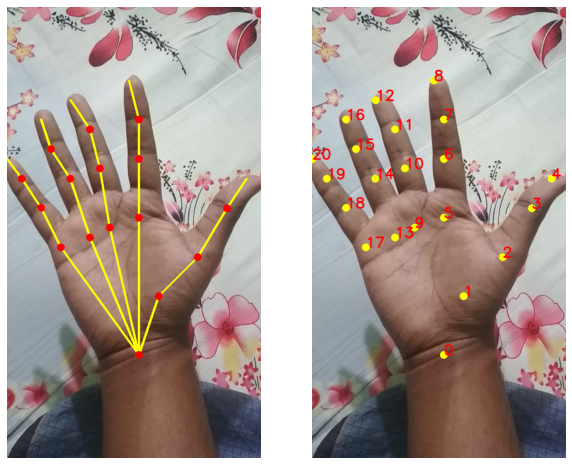

In [ ]:
modelpath = "hand_models"
pose_model = general_pose_model(modelpath)
pic = "ccc.jpg"
res_points = pose_model.predict(pic)
pose_model.vis_pose(pic, res_points)



In [ ]:
res_points

[(280, 740),
 (322, 615),
 (405, 532),
 (467, 428),
 (509, 365),
 (280, 448),
 (280, 323),
 (280, 239),
 (259, 156),
 (218, 469),
 (197, 343),
 (176, 260),
 (135, 198),
 (176, 490),
 (134, 365),
 (93, 302),
 (72, 239),
 (114, 511),
 (72, 427),
 (31, 365),
 (0, 323),
 None]